In [17]:
#importing packages 
import tensorflow as tf

from keras.datasets import mnist
import matplotlib.pyplot as plt
import cv2
import numpy as np

(trainx,trainy),(testx,testy)=mnist.load_data()


In [19]:
#functions I need
def order_corner_points(corners):
    corners = [(corner[0][0], corner[0][1]) for corner in corners]
    top_r, top_l, bottom_l, bottom_r = corners[0], corners[1], corners[2], corners[3]
    return top_l, top_r, bottom_r, bottom_l
def find_corners(img):
    ext_contours = cv2.findContours(img, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    ext_contours = ext_contours[0] if len(ext_contours) == 2 else ext_contours[1]
    ext_contours = sorted(ext_contours, key=cv2.contourArea, reverse=True)

    for c in ext_contours:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.015 * peri, True)
        if len(approx) == 4:
            return approx
def processing(img, skip_dilate=False):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    process = cv2.GaussianBlur(img.copy(), (9, 9), 0)
    process = cv2.adaptiveThreshold(process, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    process = cv2.bitwise_not(process, process)
    return process

def perspective_transform(image, corners):
    ordered_corners = order_corner_points(corners)
    top_l, top_r, bottom_r, bottom_l = ordered_corners


    width_A = np.sqrt(((bottom_r[0] - bottom_l[0])**2) + ((bottom_r[1] - bottom_l[1])**2))
    width_B = np.sqrt(((top_r[0] - top_l[0])**2) + ((top_r[1] - top_l[1])**2))
    width = max(int(width_A), int(width_B))


    height_A = np.sqrt(((top_r[0] - bottom_r[0])**2) + ((top_r[1] - bottom_r[1])**2))
    height_B = np.sqrt(((top_l[0] - bottom_l[0])**2) + ((top_l[1] - bottom_l[1])**2))
    height = max(int(height_A), int(height_B))
    dimensions = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1],
                           [0, height - 1]], dtype="float32")

    ordered_corners = np.array(ordered_corners, dtype="float32")

    grid = cv2.getPerspectiveTransform(ordered_corners, dimensions)

    return cv2.warpPerspective(image, grid, (width, height))


In [20]:
trainx = trainx.reshape(60000, 28, 28, 1)
testx = testx.reshape(10000, 28, 28, 1)
trainx=trainx/255
testx = testx / 255

In [21]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.98):
      print("Training cancelled")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
#training
model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
        
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    trainx, trainy, epochs=20, callbacks=[callbacks],
    
)


Epoch 1/20
1875/1875 [==============================] - 38s 20ms/step - loss: 0.1661 - accuracy: 0.9509
Epoch 2/20
1873/1875 [============================>.] - ETA: 0s - loss: 0.0574 - accuracy: 0.9824
Reached 9% accuracy so cancelling training!
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0574 - accuracy: 0.9824


In [ ]:
model.save('Mymodel.h5') #saving model

INFO:tensorflow:Assets written to: MyModel/assets


In [ ]:
_, acc = model.evaluate(testx, testy, verbose=0) #evaluating
print(acc)

0.9825000166893005


In [22]:
tf.keras.models.load_model("myModel.h5") #loading model after saving it

In [23]:
#function to pre process
def preProcess(img):
    if img.shape[2] == 3:

        imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        imgBlur = cv2.GaussianBlur(imgGray, (5, 5), 1)  
        imgThreshold = cv2.adaptiveThreshold(imgBlur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)  
        imgThreshold = cv2.bitwise_not(imgThreshold)
    else:
        imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        imgThreshold = cv2.bitwise_not(imgGray).astype('uint8')
    return imgThreshold

(450, 450, 3)


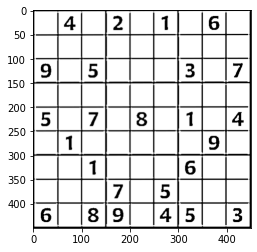

In [24]:
#loading puzzle and pre-processing it
puzzle= cv2.imread("sudo2.jpeg")[:,:,::-1]
puzzle = cv2.resize(puzzle, (450, 450))
print(puzzle.shape)
puzzle=preProcess(puzzle)

sudoku = find_corners(puzzle) #finding the 4 corners of the sudoku puzzle
#new=transformed image
new = perspective_transform(puzzle, sudoku)#warping the sudoku
new = cv2.resize(new, (450,450))
new = cv2.rotate(new, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
new = cv2.bitwise_not(new) #inverting the image
puzzle=new
plt.imshow(puzzle,cmap="Greys_r")

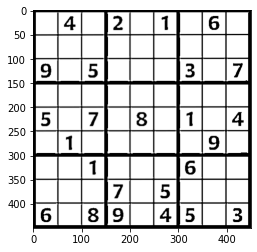

In [25]:
imgContours = puzzle.copy() 
contours, hierarchy = cv2.findContours(puzzle, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
cv2.drawContours(imgContours, contours, -1, (0,255,0), 3)
plt.imshow(imgContours,cmap="Greys_r")


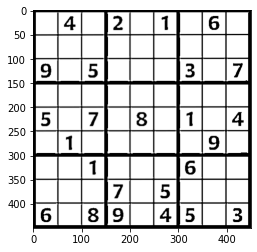

In [26]:

#splitting the sudoku images
rows = np.vsplit(imgContours,9)
plt.imshow(imgContours,cmap="Greys_r")
boxes=[]
for r in rows:
  cols= np.hsplit(r,9)
  for box in cols:
    boxes.append(box)


In [27]:

#function to get prediction
def getPredection(boxes,model):
    result = []
    for image in boxes:
      
        img = np.asarray(image)
        img = img[4:img.shape[0] - 4, 4:img.shape[1] -4]
        img = cv2.resize(img, (28, 28))
        img = img / 255
        img = img.reshape(1, 28, 28, 1)
        
        predictions = model.predict(img)
        probabilityValue = np.amax(predictions)
        pred = np.argmax(predictions, axis=-1)
        
        if probabilityValue > 0.8:
            result.append(pred[0])
        else:
            result.append(0)
    return result
result=getPredection(boxes,model)
print(result)


[0, 4, 0, 2, 0, 1, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 5, 0, 0, 0, 3, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 7, 0, 8, 0, 1, 0, 4, 0, 1, 0, 0, 0, 0, 0, 9, 0, 0, 0, 1, 0, 0, 0, 6, 0, 0, 0, 0, 0, 7, 0, 5, 0, 0, 0, 6, 0, 8, 9, 0, 4, 5, 0, 3]


In [28]:
result=np.array(result)
result=np.split(result,9)
print(result)

[array([0, 4, 0, 2, 0, 1, 0, 6, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([9, 0, 5, 0, 0, 0, 3, 0, 7]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([5, 0, 7, 0, 8, 0, 1, 0, 4]), array([0, 1, 0, 0, 0, 0, 0, 9, 0]), array([0, 0, 1, 0, 0, 0, 6, 0, 0]), array([0, 0, 0, 7, 0, 5, 0, 0, 0]), array([6, 0, 8, 9, 0, 4, 5, 0, 3])]


In [30]:
#sudoku solving functions
N = 9

def printing(arr):
	for i in range(N):
		for j in range(N):
			print(arr[i][j], end = " ")
		print()
def isSafe(grid, row, col, num):

	
	for x in range(9):
		if grid[row][x] == num:
			return False

	
	for x in range(9):
		if grid[x][col] == num:
			return False

	
	startRow = row - row % 3
	startCol = col - col % 3
	for i in range(3):
		for j in range(3):
			if grid[i + startRow][j + startCol] == num:
				return False
	return True


def solveSuduko(grid, row, col):

	
	if (row == N - 1 and col == N):
		return True
	
	
	if col == N:
		row += 1
		col = 0

	
	if grid[row][col] > 0:
		return solveSuduko(grid, row, col + 1)
	for num in range(1, N + 1, 1):
	
		
		if isSafe(grid, row, col, num):
		
			
			grid[row][col] = num

			
			if solveSuduko(grid, row, col + 1):
				return True

		
		grid[row][col] = 0
	return False


grid = result

if (solveSuduko(grid, 0, 0)):
	printing(grid)
else:
	print("no solution exists ")

	


7 4 3 2 9 1 8 6 5 
1 8 6 5 3 7 9 4 2 
9 2 5 8 4 6 3 1 7 
3 6 4 1 7 9 2 5 8 
5 9 7 6 8 2 1 3 4 
8 1 2 4 5 3 7 9 6 
4 5 1 3 2 8 6 7 9 
2 3 9 7 6 5 4 8 1 
6 7 8 9 1 4 5 2 3 
